# Dogs v Cats

A hybrid VGG / ConvNet inspired by Francois' [article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

Assumes that the fully-connected classifier weights have been saved to disk (from stage2)

In [1]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [2]:
root_path = "data/dogscats-redux/"

use_small_dataset = True
path = root_path + "sample/" if use_small_dataset else root_path

A few basic libraries that we'll need for the initial exercises:

In [3]:
from __future__ import division,print_function

import os, json, shutil, random, math
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import utils; reload(utils)
from utils import plots

Using cuDNN version 5103 on context None
Mapped name None to device cuda: Tesla K80 (0692:00:00.0)
Using Theano backend.


In [5]:
def plot_train_validation_curves(title, training_series, validation_series):
    num_epochs = len(training_series)
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, validation_series, label='validation')
    plt.plot(epochs, training_series, label='train')
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, TensorBoard
import keras.backend as K

# Define our fine-tuned VGG model

In [19]:
model = Sequential()

model.add(VGG16(include_top=False, weights='imagenet'))

# intermediate_shape = (512,7,7) # 512 7x7 features at the end of VGG16 (excluding its top)

fc_model = Sequential()
fc_model.add(Flatten(input_shape=model.output_shape[1:])) # skip the first (batch) dimension
fc_model.add(Dense(256, activation='relu'))
fc_model.add(Dropout(0.5))
fc_model.add(Dense(2, activation='softmax'))
fc_model.load_weights(root_path+'fc_weights_softmax_out_2.h5')
model.add(fc_model)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

ValueError: The shape of the input to "Flatten" is not fully defined (got (512, None, None). Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.

## train the model

In [31]:
batch_size = 16
num_epochs = 50
callbacks = []
hist = model.fit(train_data, train_labels, validation_data=(validation_data, validation_labels), 
                 batch_size=batch_size, callbacks=callbacks, nb_epoch=num_epochs)
model.save_weights(path+'kl_third_try.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 5s - loss: 2.0253 - acc: 0.8716 - val_loss: 1.1388 - val_acc: 0.9278
Epoch 2/50
20000/20000 [==============================] - 4s - loss: 1.3147 - acc: 0.9173 - val_loss: 1.0786 - val_acc: 0.9326
Epoch 3/50
20000/20000 [==============================] - 4s - loss: 1.1008 - acc: 0.9307 - val_loss: 0.9442 - val_acc: 0.9406
Epoch 4/50
20000/20000 [==============================] - 4s - loss: 1.0553 - acc: 0.9339 - val_loss: 0.6297 - val_acc: 0.9604
Epoch 5/50
20000/20000 [==============================] - 4s - loss: 1.0146 - acc: 0.9363 - val_loss: 0.6563 - val_acc: 0.9590
Epoch 6/50
20000/20000 [==============================] - 4s - loss: 0.8499 - acc: 0.9466 - val_loss: 0.6118 - val_acc: 0.9618
Epoch 7/50
20000/20000 [==============================] - 4s - loss: 0.7657 - acc: 0.9519 - val_loss: 0.6295 - val_acc: 0.9606
Epoch 8/50
20000/20000 [==============================] - 4s -

In [32]:
model.save_weights(path+'fc_weights_softmax_out_2.h5')

## evaluate performance

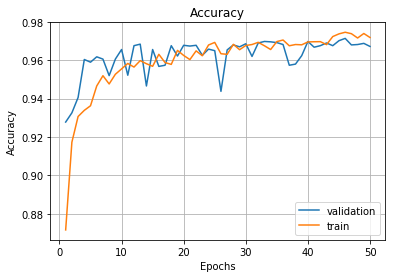

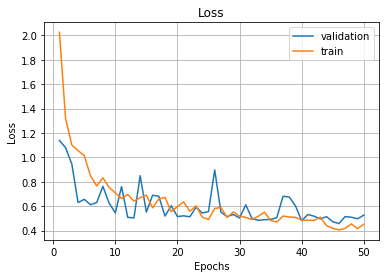

In [33]:
plot_train_validation_curves('Accuracy', hist.history['acc'], hist.history['val_acc'])
plot_train_validation_curves('Loss', hist.history['loss'], hist.history['val_loss'])

## kick the tires

In [34]:
bottlenecks, labels = train_data[:5], train_labels[:5]
print(labels)
model.predict_on_batch(bottlenecks)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

# Kaggle Submission

In [ ]:
bottlenecked_test_data = np.load(open(path+'bottleneck_features_test.npy'))

In [ ]:
bottlenecked_test_data.shape

In [ ]:
dog_predictions = model.predict_on_batch(bottlenecked_test_data)[:,1]
dog_predictions[:5]

Extract the id of each image in the test batch because Keras ImageDataGenerator will enumerate them in lexical order

In [ ]:
ids = [int(x.split("/")[1].split(".")[0]) for x in test_batches.filenames]

fill out the submission table

In [ ]:
with open(root_path + 'keith_submission_hybrid_bottleneck_stage2.csv', 'w') as f:
    f.write('id,label\n')
    for i in range(len(ids)):
        f.write('{},{}\n'.format(ids[i], dog_predictions[i]))